

## 1. Import Necessary Libraries


In [2]:
import sys
import scipy
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



### 2. The Data Set

we will import our dataset from a .csv file as a Pandas DataFrame.   

In [4]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('creditcard.csv')

In [5]:
# Then we explore then  dataset
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [6]:
# Print the shape of the data
data = data.sample(frac=0.1, random_state = 1)
print(data.shape)
print(data.describe())



(28481, 31)
                Time            V1            V2            V3            V4  \
count   28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean    94705.035216     -0.001143     -0.018290      0.000795      0.000350   
std     47584.727034      1.994661      1.709050      1.522313      1.420003   
min         0.000000    -40.470142    -63.344698    -31.813586     -5.266509   
25%     53924.000000     -0.908809     -0.610322     -0.892884     -0.847370   
50%     84551.000000      0.031139      0.051775      0.178943     -0.017692   
75%    139392.000000      1.320048      0.792685      1.035197      0.737312   
max    172784.000000      2.411499     17.418649      4.069865     16.715537   

                 V5            V6            V7            V8            V9  \
count  28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean      -0.015666      0.003634     -0.008523     -0.003040      0.014536   
std        1.395552      1.334

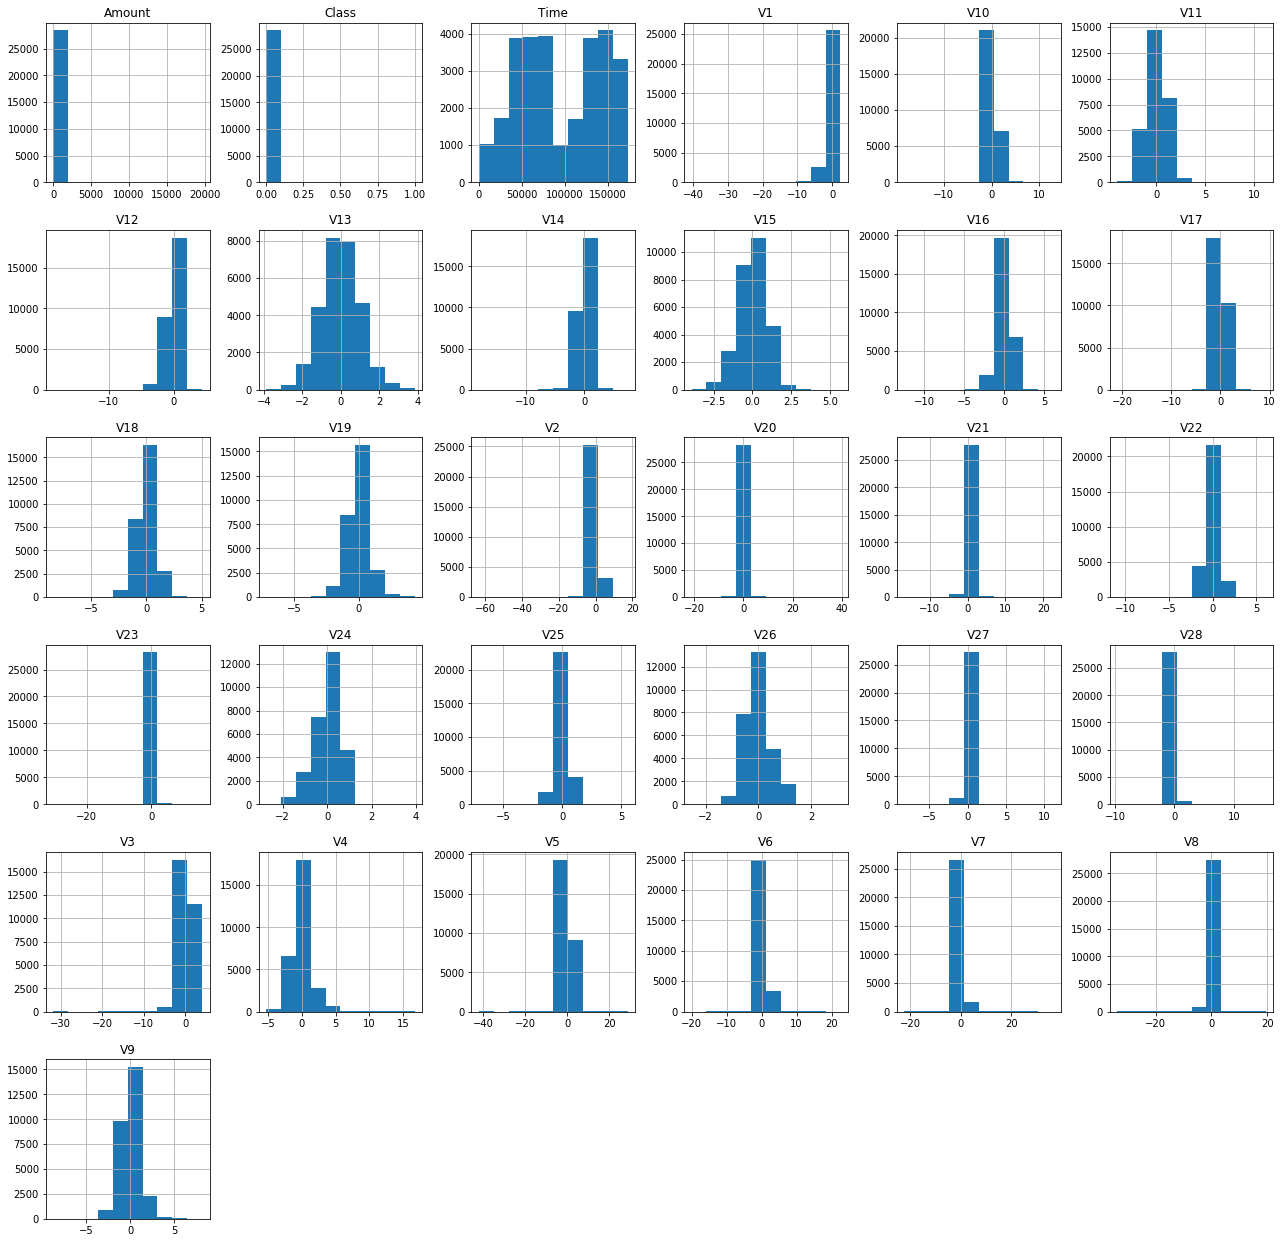

In [7]:
# Plot histograms of each parameter 
data.hist(figsize = (22, 22))
plt.show()

In [8]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]
outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)
print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017234102419808666
Fraud Cases: 49
Valid Transactions: 28432


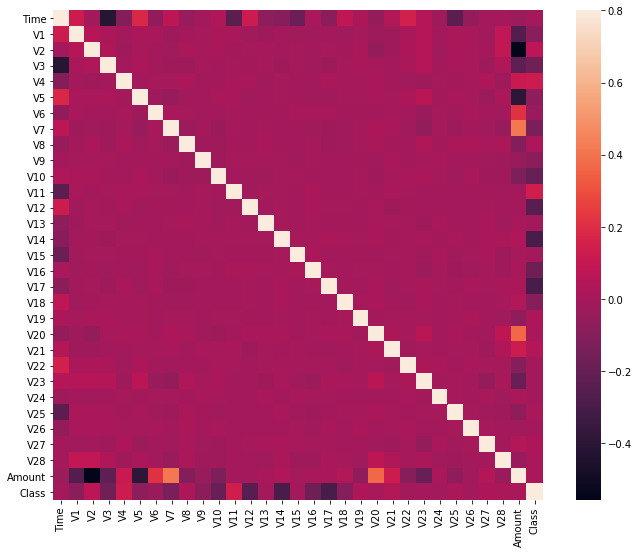

In [9]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

In [10]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()
# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we'll be predicting on
target = "Class"
X = data[columns]
Y = data[target]
# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Local Outlier Factor (LOF)**
The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood.


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.
The number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.
Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [11]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
state = 1
# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [12]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)
for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


Isolation Forest: 71
0.99750711000316
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.28      0.29      0.28        49

    accuracy                           1.00     28481
   macro avg       0.64      0.64      0.64     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



<Figure size 648x504 with 0 Axes>